In [1]:
%load_ext Cython

In [2]:
import numpy as np
import pyemma
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import h5py
#from MSMRD.trajectories import all3DTrajs
from MSMRD.discretization import partition_sphere
%matplotlib inline

In [3]:
%%cython
import numpy as np
cimport numpy as np
from multiprocessing import Pool
cdef extern from "math.h":
    double atan2(double y, double x)
    double acos(double x)
    double sqrt(double x)
    
cdef double PI = np.pi

cdef class trajDiscretization3DCython:
    cdef public object centers, numRegionsCollar, phis
    cdef public list thetas
    cdef public double innerMSMrad, entryRad, bathRad, bathRadOut, radialIncrementEntry, radialIncrementExit, numPartitions
    cdef public int angularPartitions, entryRings, exitRings, radialPartitions, Ncenters, bathIndex
    def __init__(self, np.ndarray[double, ndim=2] centers):
        self.centers = centers
        self.innerMSMrad = 2.0
        self.entryRad = 2.6
        self.bathRad = 3.0
        self.bathRadOut = 4.0
        self.angularPartitions = 48
        self.entryRings = 6
        self.exitRings = 4
        self.radialPartitions = self.entryRings + self.exitRings
        self.radialIncrementEntry = (self.entryRad - self.innerMSMrad)/float(self.entryRings)
        self.radialIncrementExit = (self.bathRad - self.entryRad)/float(self.exitRings)
        self.Ncenters = len(self.centers)
        self.bathIndex = self.Ncenters + self.radialPartitions*self.angularPartitions
        self.numPartitions = 0
        self.numRegionsCollar = None
        self.phis = None
        self.thetas = None
    
    cdef int getCollarNumber(self, np.ndarray[double, ndim=1] coord):
        cdef double rr = sqrt(coord[0]*coord[0] + coord[1]*coord[1] + coord[2]*coord[2])
        cdef double phi = acos(coord[2]/rr)
        cdef int collarNumber = np.where(self.phis<=phi)[0][-1]
        return collarNumber
    
    cdef int getAngularState(self, np.ndarray[double, ndim=1] coord, int collarNumber):
        cdef double theta = atan2(coord[1], coord[0]) + PI
        if collarNumber == 0:
            return 0
        if collarNumber == len(self.numRegionsCollar) - 1:
            return 0
        else:
            angularState = np.where(self.thetas[collarNumber-1]<=theta)[0][-1]
            return angularState
    
    cdef int getRing2(self,double radius,double increment,double lowerBound):
        return int((radius-lowerBound)/increment)
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    cdef int getState(self, np.ndarray[double, ndim=1] coord, int prevst):
        cdef double radius = np.linalg.norm(coord)
        cdef np.ndarray[double, ndim=2] cen2coord
        cdef np.ndarray[double, ndim=1] norm
        cdef int index
        cdef int collarNumber = self.getCollarNumber(coord)
        cdef int angularState = self.getAngularState(coord, collarNumber)
        cdef int prevStates
        # inner MSM
        if radius < self.innerMSMrad:
            for index in range(self.Ncenters):
                if (self.centers[index][0] - coord[0])**2 + (self.centers[index][1] - coord[1])**2 < 0.04:
                    return index
            return prevst
        # Entry states
        elif radius < self.entryRad:
            prevStates = self.Ncenters + sum(self.numRegionsCollar[0:collarNumber])
            return prevStates + (angularState + 1)
        elif radius < self.bathRad:
            prevStates = self.Ncenters + self.numPartitions + sum(self.numRegionsCollar[0:collarNumber])
            return prevStates + (angularState + 1)
        elif radius > self.bathRad:
            prevStates = self.Ncenters + 2*self.numPartitions + sum(self.numRegionsCollar[0:collarNumber])
            return prevStates + (angularState + 1)
        else:
            return prevst
        
    cpdef getdTraj(self, np.ndarray[double, ndim=2] traj):
        cdef int k, checker,i 
        cdef np.ndarray[long, ndim=1] dTraj
        # skip first elements, that might have udefined behavior.
        k = 0
        checker = self.getState(traj[0], -1)
        while checker < 0:
            k += 1
            checker = self.getState(traj[k], -1)
        dTraj = np.zeros(len(traj)-k, dtype=int)
        dTraj[0] = checker
        for i in range(1, len(traj)-k):
            dTraj[i] = self.getState(traj[i+k], dTraj[i-1])
        return dTraj
    
    cpdef getdTrajs(self, list trajs):
        cdef np.ndarray[double, ndim=2] traj
        cdef list dTrajs = []
        cdef int k, checker,i 
        for traj in trajs:
            dTrajs.append(self.getdTraj(traj))
        return dTrajs
    
    cpdef loadPartition(self, double numPartitions, np.ndarray[double, ndim=1] numRegionsCollar, np.ndarray[double, ndim=1] phis, list thetas): 
        self.numPartitions = numPartitions
        self.numRegionsCollar = numRegionsCollar
        self.phis = phis
        self.thetas = thetas

In [8]:
numfiles = 15
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym3D/test3DasymTrajs_sf2_R4_RT1e7_dt001_si10_'
dimension = 3
trajs = []
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], 10):
        print 'timestep not constant'
    traj = data[:,1:dimension+1]
    trajs.append(traj)

In [9]:
minima = [[0.0,0.0,0.0],   [1.0,0.0,-0.5] ,  [0.8, 0.9, 0.8], [-0.1,0.9,0.2], \
          [-1.0,-0.2,0.8], [-0.6,-1.0,1.2],  [0.9,-0.8,-0.7], [0.2,-1.3,1.3], \
          [-1.3,0.8,-0.7], [-1.3, 1.0,1.4],  [1.2,0.3,-1.4],  [0.5,-0.5,0.8]]
discretizer = trajDiscretization3DCython(np.array(minima))

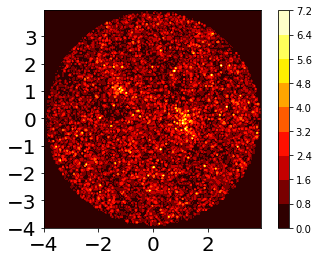

In [10]:
#plt.rcParams['figure.figsize'] = [10, 10]
MSMradius = 4.0
dzp = 0.05
dzm = 0.05
zcut = -1.0
X = np.arange(-MSMradius, MSMradius, 0.05)
Y = np.arange(-MSMradius, MSMradius, 0.05)
Zfull = np.zeros([X.shape[0]-1, X.shape[0]-1])
# Loop over trajectories
for traj in trajs:
    # Use numpy to delete coordinates in traj where condition is not satisfied
    trajproj = traj
    condition = np.invert((zcut - dzm <= trajproj[:,2]) & (trajproj[:,2] < zcut + dzp))
    indexes = np.extract(condition, np.array(range(len(traj))))
    trajproj = np.delete(trajproj, (indexes), axis=0)
    # Add result into histogram
    hist = np.histogram2d(trajproj[:,1], trajproj[:,0], bins = [X, Y], normed=False)
    Zfull += hist[0]
extent = [X[0], X[-1], Y[0], Y[-1]]
cp = plt.contourf(Zfull, 10, cmap=plt.cm.hot, extent=extent)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.colorbar()
#plt.clim(0,600)
plt.axes().set_aspect('equal')

In [11]:
numPartitions = 20
numRegionsCollar, phis, thetas = partition_sphere(numPartitions)
discretizer.loadPartition(numPartitions,numRegionsCollar,phis,thetas)

In [12]:
%%time
dTrajs = discretizer.getdTrajs(trajs)

CPU times: user 13.7 s, sys: 4.49 ms, total: 13.7 s
Wall time: 13.7 s


In [ ]:
its = pyemma.msm.its(dTrajs, lags = 100)

In [ ]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
phis

In [ ]:
max(np.where(phis<1.5)[0])+1

In [ ]:
ph

In [ ]:
numRegionsCollar

In [ ]:
thetas[1]

In [ ]:
numcollar = 2
th = 1.4
max(np.where(thetas[numcollar-1]<th)[0])

In [ ]:
thetas[numcollar-1]

In [ ]:
sum(numRegionsCollar[0:2])

In [ ]:
numRegionsCollar

In [ ]:
discretizer.numRegionsCollar

In [ ]:
len(discretizer.numRegionsCollar)

In [ ]:
discretizer.thetas

In [ ]:
max(np.where(discretizer.phis<1.4)[0])+1

In [ ]:
print discretizer.phis

In [ ]:
np.where(discretizer.phis<0.5)[0]

In [ ]:
np.where(discretizer.phis<=-1)[0][-1]

In [ ]:
discretizer.phis

In [ ]:
np.pi